## Question 1

area:  0.64
variance(calculated using the area estimation :  0.0021504


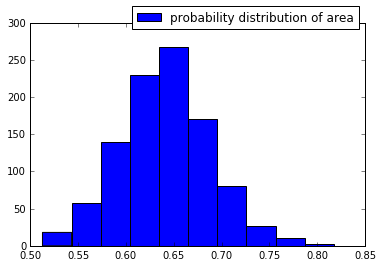

In [4]:
%matplotlib inline  
import numpy
import matplotlib.pyplot as plt
import random
import math

N=1000
p=0.5

cnt=0

for i in range(N):
    x=random.random()
    y=random.random()
    x-=0.5
    y-=0.5
    x*=2
    y*=2
    if((math.fabs(x)**p+math.fabs(y)**p)**(1.0/p)<=1.000000):
        cnt+=1

area=4.0*cnt/N

print "area: ",area
p=area/4
q=1-p
variance=p*q/N*16

print "variance(calculated using the area estimation : ",variance

r1=[]
for i in range(N):
    r1.append(random.gauss(0,math.sqrt(variance))+area)

plt.hist(r1,label="probability distribution of area")
plt.legend(bbox_to_anchor=(1.0, 1.10))
plt.show()


## Question 2

eigenvalues: 
1.0
0.25
1.42295841265e-16
-0.5
0.25
-7.25273941049e-17
eigenvector with the largest eigenvalue:
0.558156305651
0.186052101884
0.248069469178
0.496138938357
0.558156305651
0.186052101884
normalized vector: [ 0.25        0.08333333  0.11111111  0.22222222  0.25        0.08333333]
no detailed balance
tmix: 23


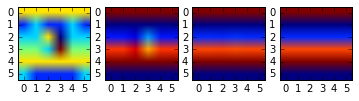

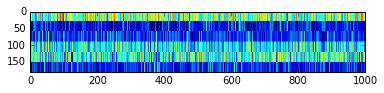

0-30 is bin1, 30-60 is bin2, 60-90 is bin3,90-120 is bin4, 120-150 is bin5, 150-180 is bin6


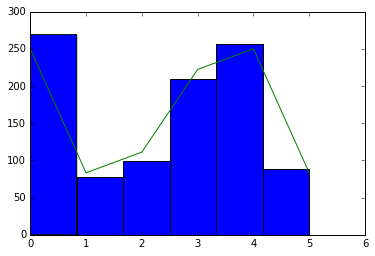

In [16]:
import numpy as np
import random
from numpy.linalg import inv,eig
from numpy import diag
import math
import matplotlib.pyplot as plt
#part a
A=[[0.25,0.25,0.25,0.25,0.25,0.25],
   [0   ,0.25,0   ,0   ,0.25,0   ],
   [0   ,0   ,0   ,0.50,0   ,0   ],
   [0.25,0.25,0.50,0   ,0.25,0.25],
   [0.25,0.25,0.25,0.25,0.25,0.25],
   [0.25,0   ,0   ,0   ,0   ,0.25]]
A=np.matrix(A)

#part b
w,v=eig(A)
print "eigenvalues: "
for i in range(6):
    print w[i]
print "eigenvector with the largest eigenvalue:"
r=[]
for i in range(6):
    print v[i,0]
    r.append(v[i,0])
sumr=sum(r)
r/=sumr
print "normalized vector:",r
#no this is not a uniform distribution

#part c
h=0
for i in range(6):
    for j in range(i+1,6):
        a=v[i,0]
        b=v[j,0]
        a=a*A[j,i]
        b=b*A[i,j]
        if(math.fabs(a-b)>0.000001):
            print "no detailed balance"
            h=1
            break
    if(h):
        break

if(h==0):
    print "yes there is detailed balance:"


#part d
def vardist(A,B):
    res=0
    for i in range(6):
        res+=math.fabs(A[i]-B[i])
    return res/2
    
epsilon=0.00000001

tmix=-1
V=A
test=np.matrix([1,0,0,0,0,0]).transpose()
for i in range(100):
    test=A*test
    if vardist(test,r)<epsilon:
       tmix=i
       break
   
print "tmix:",tmix

#part e

fig=plt.figure()
ax1=fig.add_subplot("141")
ax2=fig.add_subplot("142")
ax3=fig.add_subplot("143")
ax4=fig.add_subplot("144")
vhist=[]
for i in range(tmix):
    V=V*A
    vhist.append(V)
ax1.imshow(vhist[0])
ax2.imshow(vhist[3])
ax3.imshow(vhist[7])
ax4.imshow(vhist[tmix-1])
plt.show()

def sample(vr):
    #print vr
    u=random.random()
    cnt=0
    for i in range(6):
        cnt+=vr[i]
        if(u<=cnt):
            return i

#part f
        
Q=[[],[],[],[],[],[]]
        
for i in range(1000):
    now=0
    Xr=[0]
    for j in range(tmix):
        now=sample(A[:,now].transpose().tolist()[0])
        Xr.append(now)
    his=[0,0,0,0,0,0]
    for j in range(tmix+1):
        his[Xr[j]]+=1
    for j in range(6):
        Q[j].append(his[j])
#to make the image thicker
Q2=[]
for i in range(6):
    for j in range(30):
        Q2.append(Q[i])
        
plt.imshow(Q2)
plt.show()
print "0-30 is bin1, 30-60 is bin2, 60-90 is bin3,90-120 is bin4, 120-150 is bin5, 150-180 is bin6"
#part g
now=0
for j in range(tmix):
    now=sample(A[:,now].transpose().tolist()[0])

Xr=[]

for j in range(1000):
    now=sample(A[:,now].transpose().tolist()[0])
    Xr.append(now)

plt.hist(Xr,bins=6)
plt.plot(range(6),r*1000)
plt.show()


last plot shows that the histogram agrees with the stationary distribution(green line)